# Current Event Chat Bot
Design and implement an architecture for a small-scale LLM app that takes a user's query about
**current events** and outputs the **10 most relevant news articles** in a text format.
Your app will have access to the following data sources:

Internet: 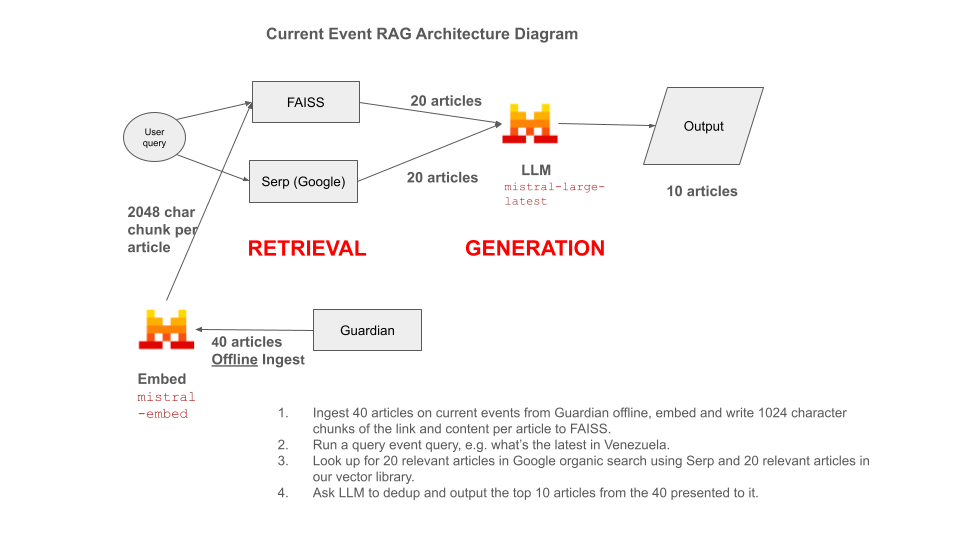Your app should be able to perform a web search and retrieve relevant results
to enrich its answers using Google's Serp.
File archive: Your app should also be able to source data from a set of archive
newspapers stored on disk, using Guardian. For the demo, you can use any public dataset of
press/newspaper archive available online.



Start by installing all the required libraries, this notebook is running on Google's Colab env.

In [ ]:
%pip install serpapi faiss-cpu==1.8.0 mistralai "numpy<2.0"

In [ ]:
from mistralai import Mistral
import serpapi
import faiss
import requests
from getpass import getpass
from datetime import date
import numpy as np
from typing import List, Dict, Tuple, Optional
import os

Embed historic news from GuardiansAPI into FAISS. First get the API Keys for Guardian's APIs.

In [ ]:
api_key_search = getpass("Type your API Key for Guardianapis")

Type your API Key for Guardianapis··········


Get 40 articles with their headline and text from Guardian's APIs.

In [ ]:

def fetch_guardian_articles(
    api_key: str,
    from_date: Optional[str] = None,
    page_size: int = 40,
    order_by: str = "newest",
) -> Optional[List[Dict[str, str]]]:
    """
    Fetch recent Guardian articles using the Guardian Content API.

    Args:
        api_key (str): Guardian API key.
        from_date (Optional[str]): Start date (YYYY-MM-DD). Defaults to today.
        page_size (int): Number of articles to retrieve.
        order_by (str): Article ordering (e.g., 'newest').

    Returns:
        Optional[List[Dict[str, str]]]:
            A list of articles with title, URL, publication date, and body text,
            or None if the request fails.
    """
    if from_date is None:
        from_date = date.today().isoformat()

    base_url = "https://content.guardianapis.com/search"

    params = {
        "api-key": api_key,
        "order-by": order_by,
        "page-size": page_size,
        "show-fields": "headline,bodyText",
        "from-date": from_date,
    }

    try:
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        results = data.get("response", {}).get("results", [])
        if not results:
            print("No articles returned from Guardian API.")
            return None

        articles = []
        for article in results:
            try:
                articles.append({
                    "title": article.get("webTitle"),
                    "url": article.get("webUrl"),
                    "published": article.get("webPublicationDate"),
                    "body_text": article.get("fields", {}).get("bodyText"),
                })
            except (TypeError, AttributeError):
                # Skip malformed entries
                continue

        return articles

    except requests.RequestException as error:
        print(f"Guardian API request failed: {error}")
        return None


In [ ]:
articles = fetch_guardian_articles(api_key_search)

if articles:
    for article in articles:
        print(f"\n📰 {article['title']}")
        print(f"📅 {article['published']}")
        print(f"🔗 {article['url']}")
        print(article["body_text"][:300], "...")


📰 Venezuelan leader Maduro lands in New York after capture by US troops – live
📅 2026-01-04T01:38:58Z
🔗 https://www.theguardian.com/world/live/2026/jan/03/caracas-explosions-venezuela-maduro-latest-news-updates-live
US Defense Secretary Pete Hegseth has spoken to CBS News about the US operation in Venezuela and what happens next. Trump earlier said the US was going to “run” Venezuela “until such time as we can do a safe, proper and judicious transition”. Asked about Trump’s comments, and whether this would mean ...

📰 Australia v England: fifth Ashes Test, day one – live
📅 2026-01-04T01:35:08Z
🔗 https://www.theguardian.com/sport/live/2026/jan/04/australia-v-england-fifth-ashes-test-day-one-live-updates-sydney-scg
23rd over: England 114-3 (Root 31, Brook 23) Neser continues and Carey, still standing up, concedes a bye – a bit of a collector’s item. Root glances for two, then edges for two more but it’s safe, angled down with soft hands. That brings up the 100, to loud cheers from the B

Get the API Keys for Mistral for Embedding and later on calling the Chat APIs.

In [ ]:
api_key_mistral = getpass("Type your API Key for Mistral")
client = Mistral(api_key=api_key_mistral)

Type your API Key for Mistral··········


In [ ]:
def get_text_embedding(input):
    """
    Generate a vector embedding for the given input text.

    Args:
        input (str or list[str]): The text (or texts) to convert into embeddings.

    Returns:
        list[float]: The embedding vector for the first input.
    """

    # Send the input text to the embeddings API using the specified model
    embeddings_batch_response = client.embeddings.create(
          model="mistral-embed",   # Embedding model to use
          inputs=input             # Text to be embedded
      )

    # Extract and return the embedding vector from the API response
    return embeddings_batch_response.data[0].embedding

Limit chunks of text to 2048 character, which is the text of each of the 40 articles.

In [ ]:

chunk_size = 2048

text_embeddings = np.array([get_text_embedding(article["body_text"][0: chunk_size]) for article in articles])
text_embeddings.shape

d = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(d)
faiss_index.add(text_embeddings)

In [ ]:
def search_guardian_articles(
    query: str,
    index,
    articles_data: dict,
    embed_fn,
    top_k: int = 20,
) -> Optional[List[str]]:
    """
    Search a vector index for Guardian article text relevant to a query.

    Args:
        query (str): The user's search query.
        index: A vector search index (e.g., FAISS index).
        articles_data (dict): Guardian API response data containing article text.
        embed_fn (callable): Function that converts text into an embedding vector.
        top_k (int): Number of similar chunks to retrieve.

    Returns:
        Optional[List[str]]:
            A list of article body text strings ordered by relevance,
            or None if an error occurs.
    """
    try:
        # Generate embedding for the query
        embedding = embed_fn(query)
        if embedding is None:
            print("Failed to generate embedding for query.")
            return None

        query_embeddings = np.array([embedding]).astype("float32")

        # Perform vector similarity search
        distances, indices = index.search(query_embeddings, k=top_k)

        if indices is None or len(indices) == 0:
            print("No search results returned from index.")
            return None

        results = []
        for i in indices[0]:
            try:
                article_text = (
                    articles_data[i]["url"] + "  " + articles_data[i]["body_text"]
                )
                if article_text:
                    results.append(article_text)
            except (IndexError, KeyError, TypeError):
                # Skip malformed or missing entries
                continue

        if not results:
            print("No valid article text found in search results.")
            return None

        return results

    except Exception as error:
        print(f"Guardian search failed: {error}")
        return None

In [ ]:
results_guardian_search = search_guardian_articles("What is the latest news on Venezuela?", index=faiss_index, articles_data=articles,
    embed_fn=get_text_embedding)

Search organic content from Google.

In [ ]:
api_key_serp = getpass("Type your API Key for SerpAPI")

Type your API Key for SerpAPI··········


In [ ]:

def google_search(
    query: str,
    api_key: str,
    num_results: int = 20,
    location: str = "Irvine, California",
    language: str = "en",
    country: str = "us",
) -> Optional[List[str]]:
    """
    Perform a Google search using SerpApi and return the top result.

    Args:
        query (str): The search query.
        api_key (str): SerpApi API key.
        num_results (int): Number of search results to request.
        location (str): Search location.
        language (str): Language code (hl).
        country (str): Country code (gl).

    Returns:
        Optional[Tuple[str, str]]:
            A tuple containing (link, snippet) of the top result,
            or None if no results are found or an error occurs.
    """
    try:
        response = serpapi.search(
            q=query,
            engine="google",
            api_key=api_key,
            num=num_results,
            location=location,
            hl=language,
            gl=country,
        )

        organic_results = response.get("organic_results")

        if not organic_results:
            print("No organic search results found.")
            return None

        results = []
        for result in organic_results:
            results.append(result.get("link") + " " + result.get("snippet"))

        return results

    except Exception as error:
        print(f"Search failed: {error}")
        return None

In [ ]:
google_search_result = google_search("what's the latest on the Ukrain war", api_key=api_key_serp)

['https://www.bbc.com/news/war-in-ukraine /nMissile attack on Kharkiv kills two including child, authorities say · Russia accuses Ukraine of killing 27 people in New Year attack in occupied Kherson region.',
 "https://apnews.com/hub/russia-ukraine /nAs the war in Ukraine unfolds, here's what you need to know. Get the latest developments as Russia's attacks continue.",
 "https://www.cnn.com/world/europe/ukraine /nLatest News · Ukraine's Zelensky offers peace concessions – and puts the ball in Putin's court · The shadow Russia casts over Europe has forced it to face the ...",
 'https://www.reuters.com/world/ukraine-russia-war/ /nRussia says it can prove that Ukraine tried to strike Putin residence. A Russian military chief gave a U.S. attaché what he said was part of a Ukrainian drone.',
 'https://www.nytimes.com/news-event/ukraine-russia /nA bitter and bloody war in Ukraine has devastated the country, further isolated Russia from the West and fueled economic insecurity around the world.

Final solution for user's question about current events and fetching top 10 articles.

In [ ]:
question = 'What is the latest news on Venezuela?'

google_search_results = google_search(question, api_key=api_key_serp)
guardian_results = results_guardian_search = search_guardian_articles(question, index=faiss_index, articles_data=articles,
    embed_fn=get_text_embedding)

In [ ]:

prompt = f"""
Google search results:
---------------------
{google_search_results}

Archival search results from Guardian:
{guardian_results}
---------------------
Given the current event update from Oragic Google Search and Guardian's archival search and not prior knowledge, answer the query.
Remove duplicate current events from the summary and output 10 most relevant articles, itemize them.
Put each article on a separate paragraph with the link first.

Query: {question}
Answer:
"""

In [ ]:
def run_mistral_chat(
    user_message: str,
    client,
    model: str = "mistral-large-latest",
    system_prompt: Optional[str] = None,
) -> Optional[str]:
    """
    Send a chat message to a Mistral model and return the assistant's response.

    Args:
        user_message (str): The user's input message.
        client: An initialized Mistral client instance.
        model (str): The Mistral model to use.
        system_prompt (Optional[str]): Optional system instruction.

    Returns:
        Optional[str]:
            The assistant's response text, or None if an error occurs.
    """
    try:
        # Build message list
        messages = []

        if system_prompt:
            messages.append({
                "role": "system",
                "content": system_prompt
            })

        messages.append({
            "role": "user",
            "content": user_message
        })

        # Send request to Mistral
        chat_response = client.chat.complete(
            model=model,
            messages=messages
        )

        # Safely extract the assistant response
        choices = getattr(chat_response, "choices", None)
        if not choices:
            print("No choices returned from Mistral.")
            return None

        message = getattr(choices[0], "message", None)
        if not message or not getattr(message, "content", None):
            print("Response message is missing content.")
            return None

        return message.content

    except Exception as error:
        print(f"Mistral chat failed: {error}")
        return None

Final Solution, calling Mistral LLM to deduplicate results from google search and Guardian and summarize

In [ ]:
run_mistral_chat(prompt, client)

'Here are the 10 most relevant and non-duplicate articles summarizing the latest news on Venezuela:\n\n1. **[CBS News: US military strikes in Venezuela, Maduro captured](https://www.cbsnews.com/live-updates/venezuela-us-military-strikes-maduro-trump/)**\n   The U.S. conducted a large-scale military strike in Venezuela, resulting in the capture of President Nicolás Maduro and his wife, Cilia Flores. President Donald Trump announced that the U.S. would temporarily "run" Venezuela until a transition of power is secured.\n\n2. **[CNN: Maduro captured after US military operation](https://www.cnn.com/world/live-news/venezuela-explosions-caracas-intl-hnk-01-03-26)**\n   Venezuelan President Nicolás Maduro was captured and flown out of Venezuela following a U.S. military operation. The U.S. claims Maduro will face federal drug charges in New York.\n\n3. **[The Guardian: US attacks Venezuela, captures Maduro](https://www.theguardian.com/world/2026/jan/04/albanese-calls-for-peaceful-democratic-t